![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # Регулярные выражения

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# ФУНКЦИИ ДЛЯ EDA
#### ЗАИМСТВОВАНЫ ####

In [4]:
def draw_boxplot(data, column):
    """Функция упрощает отрисовку boxplot для анализируемого столбца и столбца score """
    sns.set(rc={'figure.figsize':(7,5)}, font_scale=1.5, style='whitegrid')
    sns.boxplot(x=data[column])


def draw_hist_joinplot(dt, column, column_bins):
    """Функция отрисовывает гистограмму и jointplot для столбца column
     в интервале (perc25 - 1.5 * IQR, perc75 +  1.5 * IQR) и для столбща столбца 'Rating'"""
   
    median = dt[column].median()
    IQR = dt[column].quantile(0.75) - dt[column].quantile(0.25)
    perc25 = dt[column].quantile(0.25)
    perc75 = dt[column].quantile(0.75)

    if perc75 != perc25:
        dt[column][dt[column].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)].hist(bins=column_bins, label='IQR')
        plt.legend()
        sns.jointplot(x=column, y='Rating', data=dt[dt[column] < perc75 + 1.5 * IQR], kind='reg')
    else:
        dt[column].hist(bins=column_bins, label='All data')
        plt.legend()
        sns.jointplot(x=column, y='Rating', data=dt)

        
def print_data_col_info(data, column_a, column_b):
    """Функция выводит информацию о количестве выбросов, 
    пустых значений, коэфф. корреляции, ..."""

    display(pd.DataFrame(data[column_a].value_counts()))
    median = data[column_a].quantile(0.5)
    IQR = data[column_a].quantile(0.75) - data[column_a].quantile(0.25)
    perc25 = data[column_a].quantile(0.25)
    perc75 = data[column_a].quantile(0.75)      
    print('Информация по столбцу - '+ column_a+ ':')
    if column_a != column_b:
        Kcor = round(
            data[[column_a, column_b]].corr(method='pearson')[column_a][1], 3)
    else:
        Kcor = 1
    nan = int(len(data) -
              data[column_a].describe()[0])  # количество 'nan' значений

    left_border = len(data[data[column_a] < perc25 - 1.5 * IQR])
    right_border = len(data[data[column_a] > perc75 + 1.5 * IQR])

    outliers = left_border + right_border

    print(
        " 25-й перцентиль: {},\n".format(perc25),
        "75-й перцентиль: {},\n".format(perc75),
        "Медиана: {},\n".format(median), "IQR: {},\n".format(IQR),
        "Количество 'nan' значений: {},\n".format(nan),
        "Количество выбросов: {}, слева: {}, справа: {}\n".format(
            outliers, left_border, right_border),
        "Границы выбросов: [{f}, {l}],\n".format(f=perc25 - 1.5 * IQR,
                                                 l=perc75 + 1.5 * IQR),
        "Kоэф. корреляции между \'{}\' и \'{}\' : {},\n".format(
            column_a, column_b, Kcor))


def draw_nomin_hist(data, column, column_beans):
    """Функция отрисовыват гистограмму для номинативных признаков"""
    
    data[column].hist(bins=column_beans)


def print_nomin_info(data, column):   
    """Функция выводит информацию о номинативном признаке """
    
    data[column] = data[column].astype(str).apply(lambda x: None if x.strip() == '' else x)
    display(pd.DataFrame(data[column].value_counts()))
    print("Значений, встретившихся в столбце более 10 раз:",
          (data[column].value_counts() > 10).sum())
    print("Уникальных значений:", data[column].nunique())
    print(data.loc[:, [column]].info())
    data[column].value_counts(ascending=True).plot(kind='bar')

# DATA

In [5]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
# Подгружаем заранее локально подготовленный датасет с популяцией в нужных городах
df_2 = pd.read_csv('city_population.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Добавим население городов в датасет

In [7]:
# Переименуем Город "Опорто" в "Порто"
data['City'] = data['City'].apply(lambda x: 'Porto' if x=='Oporto' else x)
# Пополняем датасет населением городов
data = data.merge(df_2, on='City', how='left')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  population         50000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 5.0+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана
* population: население в соответствующем городе

In [9]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population
25076,id_3297,Madrid,['Spanish'],3299.0,$$ - $$$,62.0,"[['My new favorite coffeeplace in Madrid', 'Ch...",/Restaurant_Review-g187514-d2343603-Reviews-Ba...,d2343603,1,4.0,6026000.0
48796,id_780,Stockholm,"['Sushi', 'Japanese']",781.0,$$ - $$$,22.0,"[['Excellent food, but stressed waitress', 'Be...",/Restaurant_Review-g189852-d4411692-Reviews-He...,d4411692,1,4.5,972647.0
10015,id_1401,Dublin,['Cafe'],1405.0,$$ - $$$,28.0,"[['Lovely food', 'Great coffee'], ['12/01/2017...",/Restaurant_Review-g186605-d6633059-Reviews-Gr...,d6633059,1,4.0,1173179.0
29392,id_1431,Vienna,"['Austrian', 'European', 'Wine Bar']",1432.0,NaN,8.0,"[[], []]",/Restaurant_Review-g190454-d7284049-Reviews-He...,d7284049,1,4.5,1911191.0
38189,id_2587,Rome,"['Japanese', 'Sushi', 'Soups']",2588.0,$$ - $$$,333.0,"[['Informal, fresh, good quality.', ""I'm not a...",/Restaurant_Review-g187791-d4501239-Reviews-Su...,d4501239,1,4.0,2872800.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [10]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [11]:
data['Number_of_Reviews_isNAN'].value_counts()

0    46800
1     3200
Name: Number_of_Reviews_isNAN, dtype: int64

In [12]:
# Далее заполняем пропуски 0
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [13]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
population                    31
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

### Создадим новый признак: если id повторяется, то 1 - сетевой ресторан, 0 - нет
Признак вклада в MAE не дал. В дальнейшем был удалён

In [14]:
####### Заимствованный признак у Aleksandr Kravchenko #######

chain_lst = list(data.Restaurant_id.value_counts()[data.Restaurant_id.value_counts() > 1].index)

data['chain'] = data[data.Restaurant_id.isin(chain_lst)].Restaurant_id.apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)

### Модифицируем признак ID_TA

In [15]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

### Сгенерируем новый признак: относительный рейтинг ресторанов внутри городов

In [16]:
# Сформируем словарь: {город: максимальный ранкинг в этом городе}
max_city_rank = {}
for city in data['City'].value_counts().index:
    max_city_rank[city] = data[data['City']==city]['Ranking'].max()

# Создаём новый признак
data['city_ranking'] = data[['Ranking', 'City']].apply(lambda row: row[0] / max_city_rank[row[1]], axis=1)

### Сгенерируем новый признак: медианная зарплата для городов

In [17]:
City_salary_dict = {'Paris': 2600,
                     'Stockholm': 2750,
                     'London': 4131,
                     'Berlin': 5120,
                     'Munich': 5000,
                     'Porto': 3100,
                     'Milan': 5000,
                     'Bratislava': 1350,
                     'Vienna': 5350,
                     'Rome': 1700,
                     'Barcelona': 6700,
                     'Madrid': 1900,
                     'Dublin': 3000,
                     'Brussels': 4300,
                     'Zurich': 6600,
                     'Warsaw': 5000,
                     'Budapest': 3840,
                     'Copenhagen': 2580,
                     'Amsterdam': 3300,
                     'Lyon': 5152,
                     'Hamburg': 4400,
                     'Lisbon': 1400,
                     'Prague': 1400,
                     'Oslo': 3600,
                     'Helsinki': 5900,
                     'Edinburgh': 5000,
                     'Geneva':13000,
                     'Ljubljana':2350,
                     'Athens': 890,
                     'Luxembourg': 5900,
                     'Krakow': 2150
                    }

data['salary'] = data['City'].apply(lambda x: City_salary_dict[x] if True else 0)

### Сгенерируем новый признак: количество ресторанов внутри данного города
Количество ресторанов внутри данного города в такой же ценовой категории даёт MAE хуже

In [18]:
data['rest_in_city'] = data.groupby(["City"])['Restaurant_id'].transform('count')


######### ВАРИАНТ, КОТОРЫЙ РАБОТАЕТ ДОЛГО #########

# data['Count_of_rest_in_City'] = data.apply(lambda row: data[data['City']==row.City]['City'].count(), axis=1)
# data['Rest_in_City_in_the_PR'] = data.apply(lambda row: data[(data['City']==data.City) & (data['Price Range']==row['Price Range'])]['City'].count(), axis=1)

### Сгенерируем новый признак: количество отзывов внутри данного города

In [19]:
data['Reviews_in_the_city'] = data.groupby(["City"])['Number of Reviews'].transform('sum')

### Сгенерируем новый признак: соотношение ранкинга к количеству отзывов внутри данного города

In [20]:
data['Ranking_to_Review_number_in_the_city'] = data['Ranking'] / data['Reviews_in_the_city']

### Сгенерируем новые признаки: медианное количество отзывов в данном городе и отношение ранкинга к этому признаку

In [21]:
data['Reviews_in_the_city_median'] = data.groupby(["City"])['Number of Reviews'].transform('median')
data['Ranking_to_median_Review_number_in_the_city'] = data['Ranking'] / data['Reviews_in_the_city_median']

### Создание dummy-признаков для City

In [22]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)



######### ВАРИАНТ, КОТОРЫЙ РАБОТАЕТ ХУЖЕ #########

# Берём N % самых частых городов
# cities_with_freqs = data.City.value_counts()
# mask = data.City.isin(cities_with_freqs[cities_with_freqs >= np.percentile(cities_with_freqs, 50)].index)
# data.City[~mask] = 'Other City'
# data = pd.get_dummies(data, columns=['City'])

#### Возьмем следующий признак "Price Range".

In [23]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [24]:
# Ваша обработка 'Price Range'
# Предлагается заменить значения на 1, 2 и 3, соответственно по возрастанию цены
# Для этого используем функцию
def price_range_replace(x):
    if x == '$':
        return 1
    if x == '$$ - $$$':
        return 2
    if x == '$$$$':
        return 3

data['Price Range'] = data['Price Range'].apply(price_range_replace)

In [25]:
# Заполним пропуски модой
data['Price Range'] = data['Price Range'].fillna(data['Price Range'].mode()[0])

### Разбираемся со столбцом Reviews — данные о двух отзывах, которые отображаются на сайте ресторана

In [26]:
# Посмотрим как выглядит случайный элемент признака
data['Reviews'].iloc[12011]

"[['Value for money', 'Great meal'], ['10/25/2017', '10/16/2017']]"

### Создадим новый признак - количество дней между отзывами, год первого отзыва и год второго отзыва

In [27]:
# Удалим лишнее
data['Reviews'] = data['Reviews'].str.replace('[', '').str.replace(']', '').str.replace("'", '')

<ipython-input-27-6483b6b70d8c>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['Reviews'] = data['Reviews'].str.replace('[', '').str.replace(']', '').str.replace("'", '')


In [28]:
# Заполним пропуски фейковой датой 10/10/2017
data['Reviews'] = data['Reviews'].apply(lambda s: '10/10/2017, 10/10/2017' if s == ', ' else s)
data['Reviews'] = data['Reviews'].fillna('10/10/2017, 10/10/2017')

In [29]:
# Вытянем даты, используя регулярные выражения и запишем в новую колонку
data['just_date'] = data['Reviews'].dropna().apply(lambda s: re.findall(r'\d+/\d+/\d+', s))

In [30]:
# Проверим сколько дат может быть, кроме заявленных двух
data['just_date'].apply(lambda s: len(s)).value_counts()

2    44316
1     5680
3        4
Name: just_date, dtype: int64

* пустые значения заполним двумя фэйковыми датами 10/10/2017
* к данным c одной датой добавить такую же дату
* в данных с тремя датами оставить две

In [31]:
def date_modify(date):
    if len(date)==2:
        return date
    elif len(date)==1:
        date.append(date[0])
        return date
    elif len(date)==3:
        del date[2]
        return date
    else:
        date.append('10/10/2017')
        date.append('10/10/2017')
        return date
    
data['just_date'] = data['just_date'].apply(date_modify)
data['just_date'].apply(lambda s: len(s)).value_counts()

2    50000
Name: just_date, dtype: int64

### Создадим два признака с датами в формате datetime и найдём разницу в днях между ними

In [32]:
data['first_date'] = data['just_date'].apply(lambda date: pd.to_datetime(date).min(), '%m/%d%/%Y')
data['second_date'] = data['just_date'].apply(lambda date: pd.to_datetime(date).max(), '%m/%d%/%Y')
data['date_of_review_differece'] = (data['second_date'] - data['first_date']).dt.days

Проверим разницу дат на выбросы

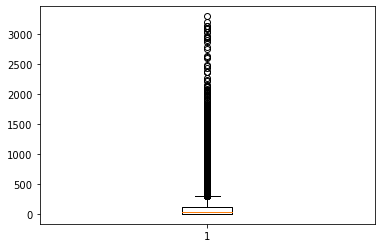

In [33]:
plt.boxplot(data['date_of_review_differece'].values);

Оказалось, что замена выбросов с использованием IQR метода приводит к уменьшению MAE. Поэтому ниже приведён лишь закомментированный код для этого

In [34]:
# # Заменим выбросы по IQR методу
# def IQR_modification(column):
#     Q1 = data[column].quantile(0.25)
#     Q3 = data[column].quantile(0.75)
#     IQR = Q3 - Q1
#     data[column] = data[column].apply(lambda x: data[column].median() if (x>(Q3+1.5*IQR)) or (x<(Q1-1.5*IQR)) else x)

# IQR_modification('date_of_review_differece')

### Сгенерируем новый признак: сезоны года в отзывах

In [35]:
def make_season(date):
    '''
    Время года отзыва
    '''
    if (pd.isna(date)):
        return "nan"
    month = date.month
    if (month == 12 or month <= 2):
        return "WINTER"
    elif (3 <= month <= 5):
        return "SPRING"
    elif (6 <= month <= 8):
        return "SUMMER"
    else:
        return "FALL"

data['Season'] = data['first_date'].apply(make_season)
data['Season_2'] = data['second_date'].apply(make_season)

data = pd.get_dummies(data, columns=['Season',], dummy_na=True)
data = pd.get_dummies(data, columns=['Season_2',], dummy_na=True)

#### Создадим суммарный признак сезонов по двум отзывам

In [36]:
list_of_season = ["nan", "WINTER", "SPRING", "SUMMER", "FALL"]
for season in list_of_season:
    data['Seasons_' + season] = data['Season_' + season] + data['Season_2_' + season]

# Удалим промежуточные столбцы
data.drop(columns=['Season_FALL', 'Season_SPRING', 'Season_SUMMER',
                   'Season_WINTER', 'Season_nan', 'Season_2_FALL',
                   'Season_2_SPRING', 'Season_2_SUMMER', 'Season_2_WINTER',
                   'Season_2_nan', 'Seasons_nan'], axis=1, inplace=True)
print('')

### Сгенерируем новый признак: в выходной или будний день посетитель был в ресторане

In [37]:
data['holiday_1'] = data['first_date'].apply(lambda x: 0 if (x.weekday() < 5) else 1)
# Добавление второго аналогичного признака ухудшает модель, как и их сумма
# data['holiday_2'] = data['second_date'].apply(lambda x: 0 if (x.weekday() < 5) else 1)

### Разберёмся с кухнями
В процессе экспериментов было выявлено, что наличие 10% самых часто встречающихся кухонь, как и 10% самых редких кухонь, в качестве dummy-признаков не даёт весомого вклада MAE. Весомым оказалось количество кухонь. Тем не менее, некоторое количество кухонь решено было оставить в качестве dummy

In [38]:
# Сформируем множество из кухонь
cuisine_set = set()
for line in data['Cuisine Style'].dropna():
    line = line.replace('[', '').replace(']', '').replace("'",'').split(', ')
    for cuisine in line:
        cuisine_set.add(cuisine)

# Убираем лишнее
data['Cuisine Style'] = data['Cuisine Style'].str.replace('[', '').str.replace(']', '').str.replace("'", "")
data['Cuisine Style'] = data['Cuisine Style'].dropna().apply(lambda s: s.split(', '))

# Заполним пропуски
data['Cuisine Style'] = data['Cuisine Style'].fillna('No info about cuisine')
cuisine_set.add('No info about cuisine')
        
# Сформируем словарь в виде
# {'название кухни': количество раз, которое встретилась кухня в датасете}
cuisine_dict = {}
for cuisine in cuisine_set:
    cuisine_dict[cuisine] = 0
    for line in data['Cuisine Style']:
        if cuisine in line:
            cuisine_dict[cuisine] += 1    

# Создадим dummy-признаки 10% наиболее часто встречающихся кухонь
most_frequency_cuisine = list(cuisine_dict.values())
most_frequency_cuisine.sort(reverse=True)
most_frequency_cuisine = most_frequency_cuisine[:len(most_frequency_cuisine)//10]

most_frequency_cuisine_names = []
for each, value in cuisine_dict.items():
    if value in most_frequency_cuisine:
        most_frequency_cuisine_names.append(each)
        
for cuisine in most_frequency_cuisine_names:
    data[cuisine] = data['Cuisine Style'].apply(lambda row: 1 if cuisine in row else 0) 
                

# Создаём признак "Количество кухонь в ресторане"        
data['Cuisine_count'] = data['Cuisine Style'].apply(lambda x: 1 if str(x)=='nan' else len(x))

<ipython-input-38-3f9d011862ae>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['Cuisine Style'] = data['Cuisine Style'].str.replace('[', '').str.replace(']', '').str.replace("'", "")


### Создадим новый признак: связь ранкинга ресторана с числом отзывов

In [39]:
data['Quotient_Ranking-Number_of_Reviews'] = data['Ranking'] * data['Number of Reviews']

### Создадим новый признак: отношение населения города к ранкингу


In [40]:
data['population_to_ranking'] = data['population'] / data['Ranking']

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

<AxesSubplot:>

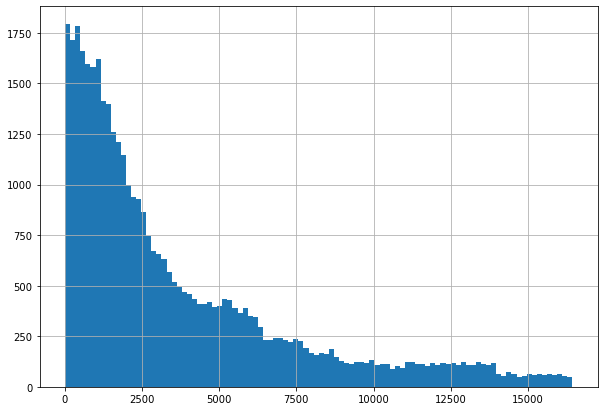

In [41]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

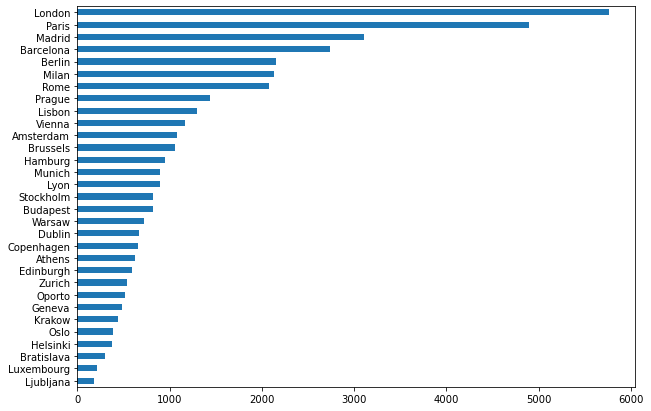

In [42]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

<AxesSubplot:>

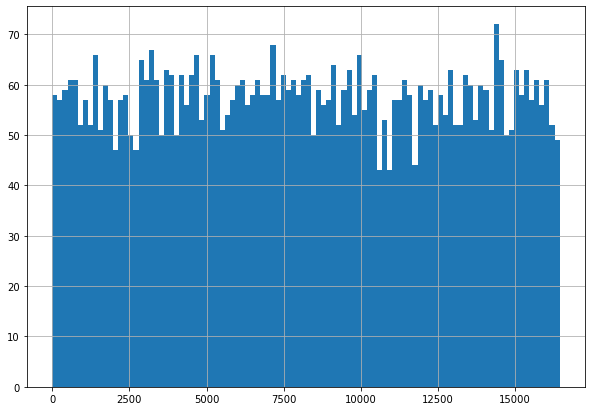

In [43]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

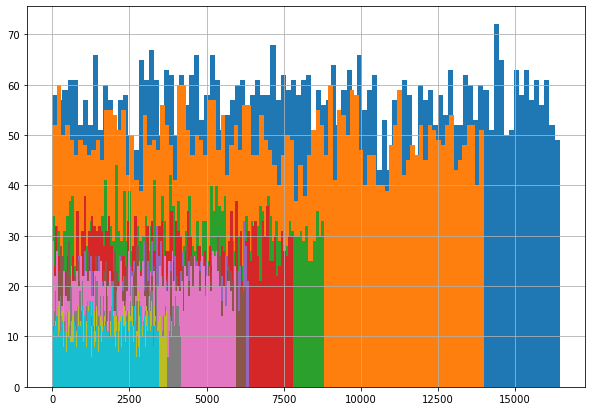

In [44]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

<AxesSubplot:>

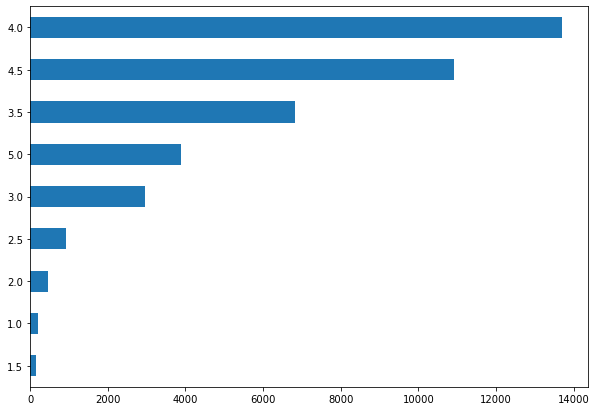

In [45]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

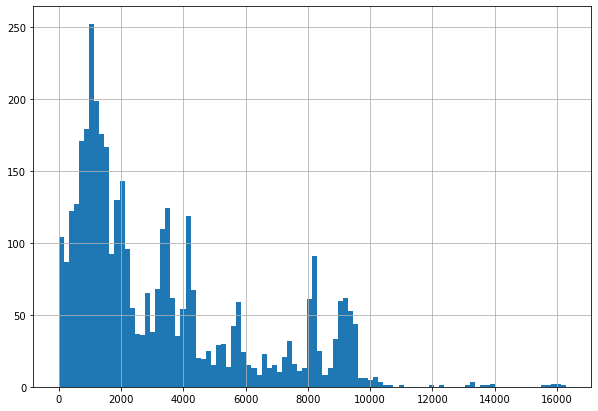

In [46]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

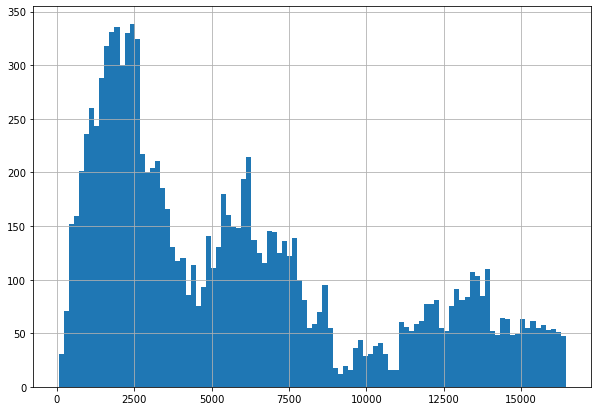

In [47]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

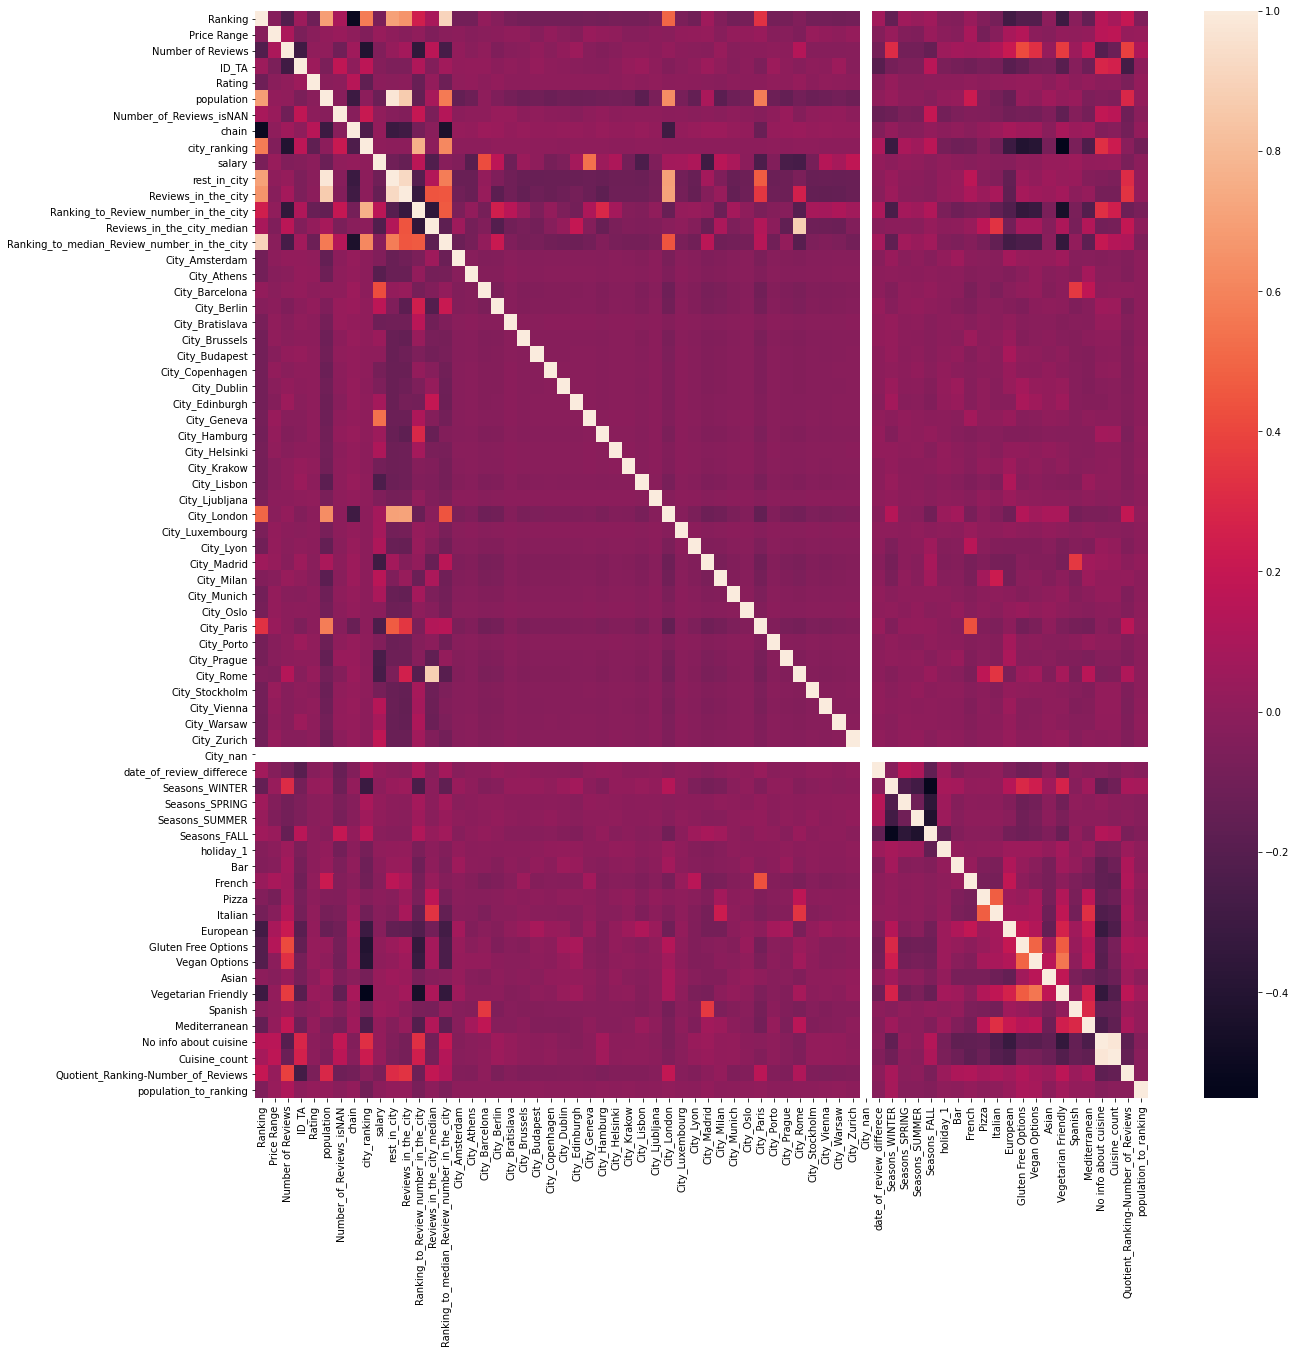

In [48]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

=> City_nan, No info about cuisine и rest_in_city необходимо удалить, поскольку эти признаки слишком коррелируют с другими нецелевыми.

Удаление 'City_Rome' ухудшает модель

In [49]:
data.drop(['City_nan', 'No info about cuisine', 'rest_in_city'], axis=1, inplace=True)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

### Проанализируем население

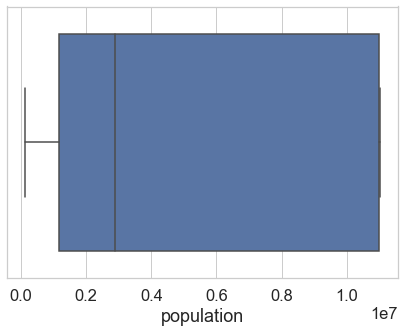

In [50]:
draw_boxplot(data, 'population')

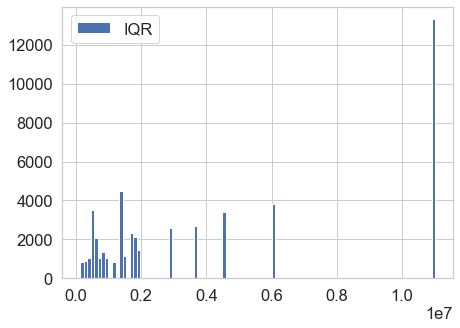

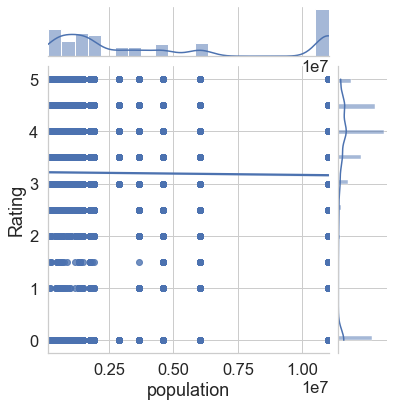

In [51]:
draw_hist_joinplot(data, 'population', 100)

### Посмотрим распределение Ranking по городам в зависимости от целевой переменной Rating

No handles with labels found to put in legend.


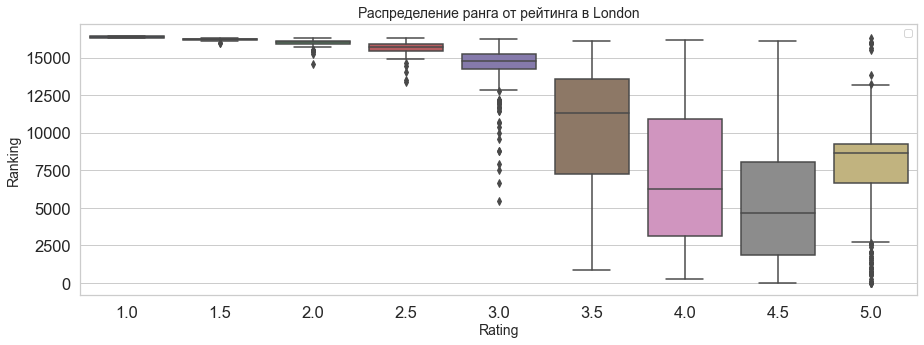

No handles with labels found to put in legend.


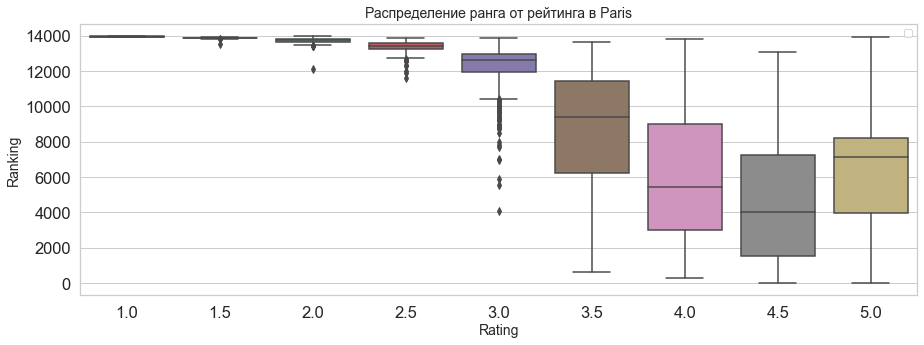

No handles with labels found to put in legend.


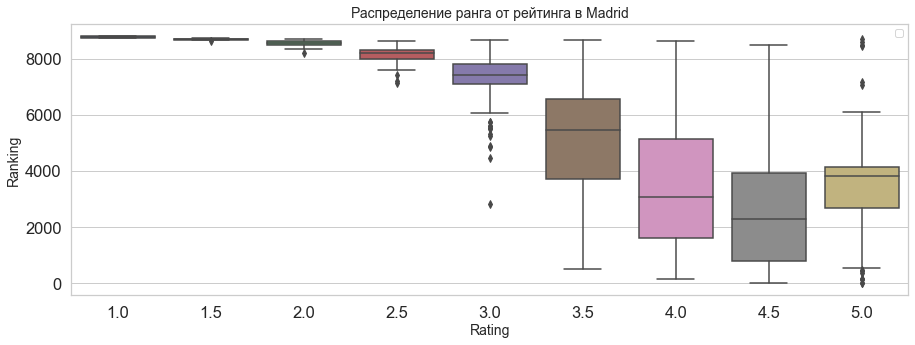

No handles with labels found to put in legend.


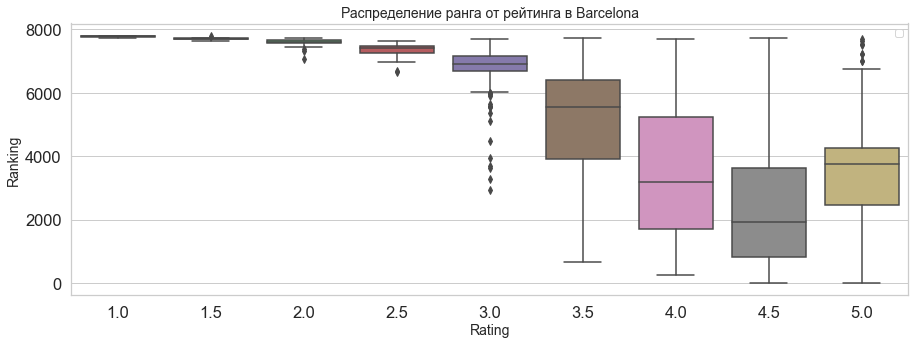

No handles with labels found to put in legend.


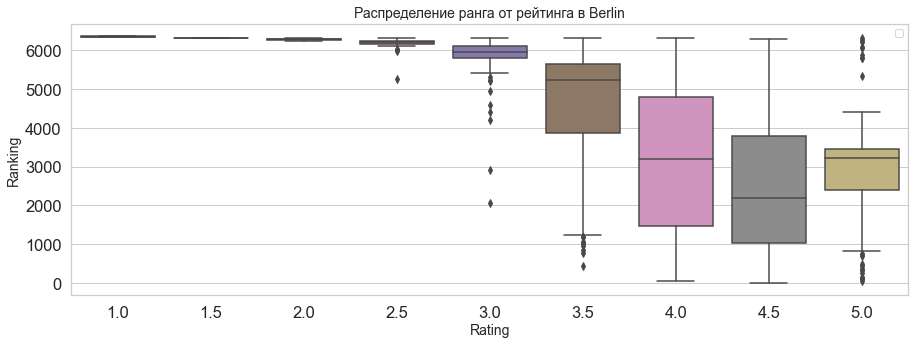

No handles with labels found to put in legend.


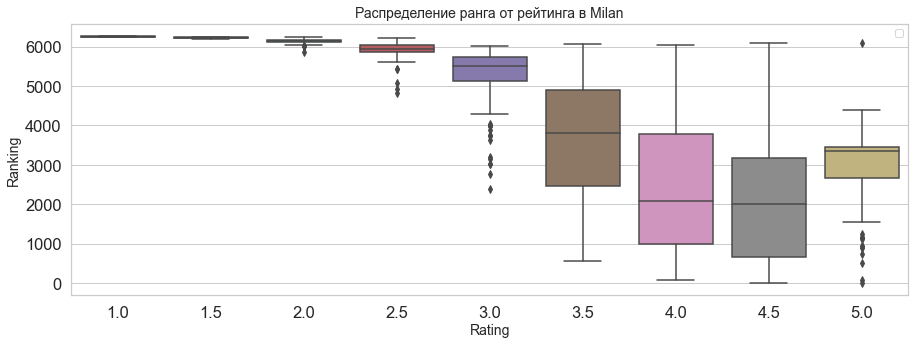

No handles with labels found to put in legend.


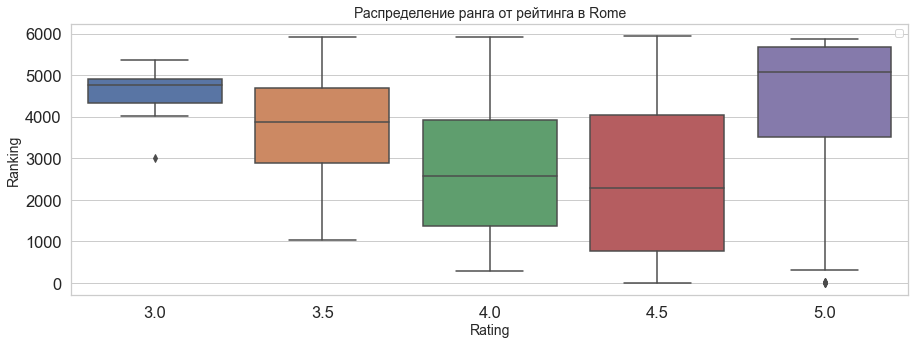

No handles with labels found to put in legend.


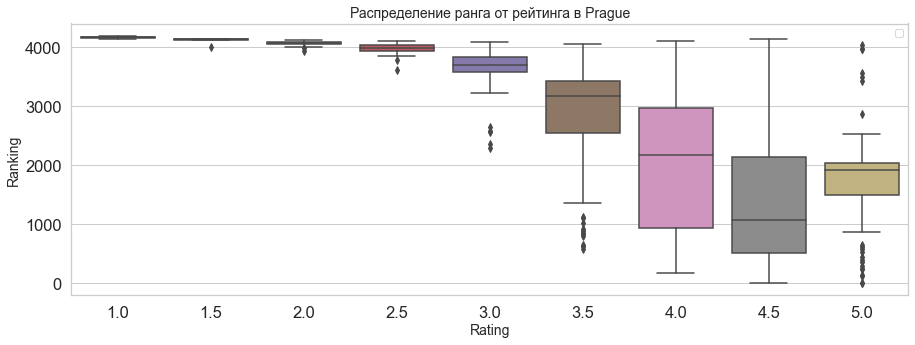

No handles with labels found to put in legend.


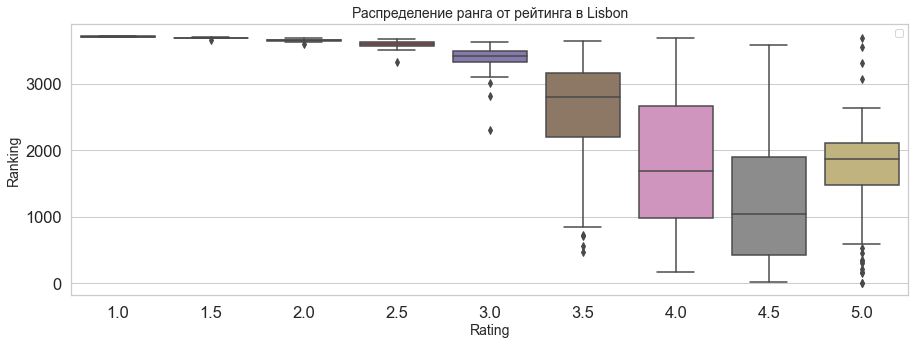

No handles with labels found to put in legend.


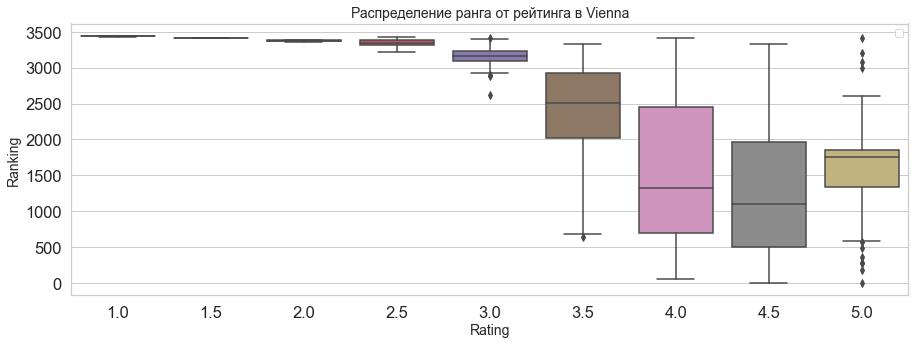

No handles with labels found to put in legend.


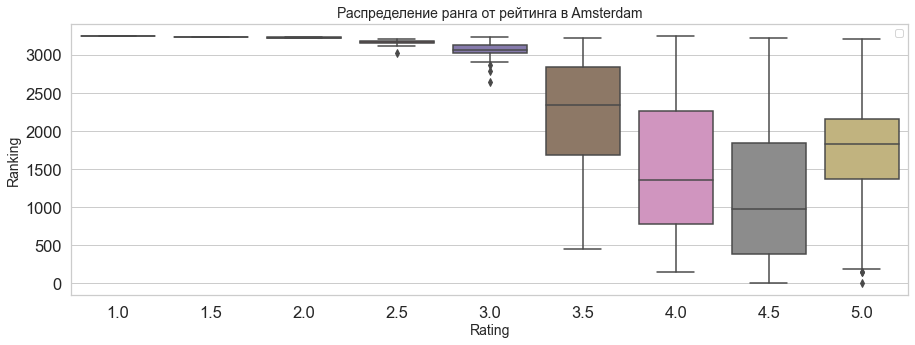

No handles with labels found to put in legend.


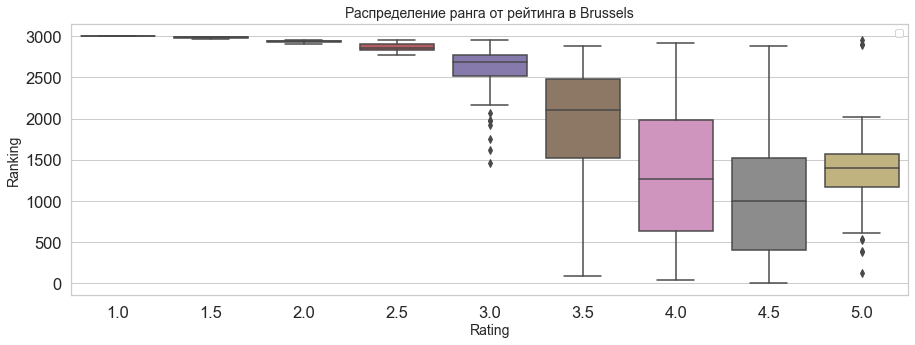

No handles with labels found to put in legend.


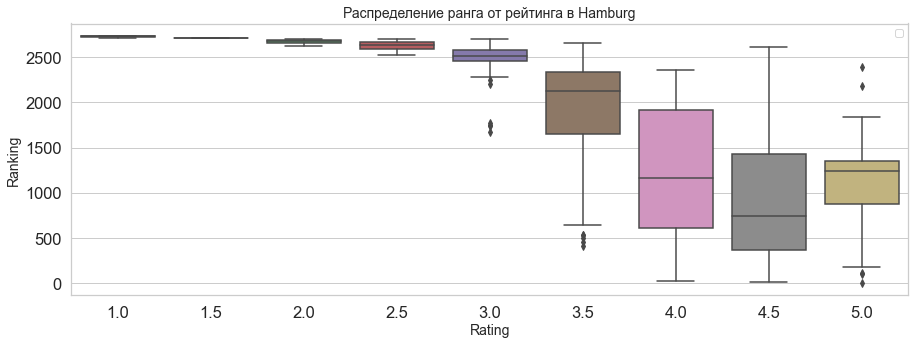

No handles with labels found to put in legend.


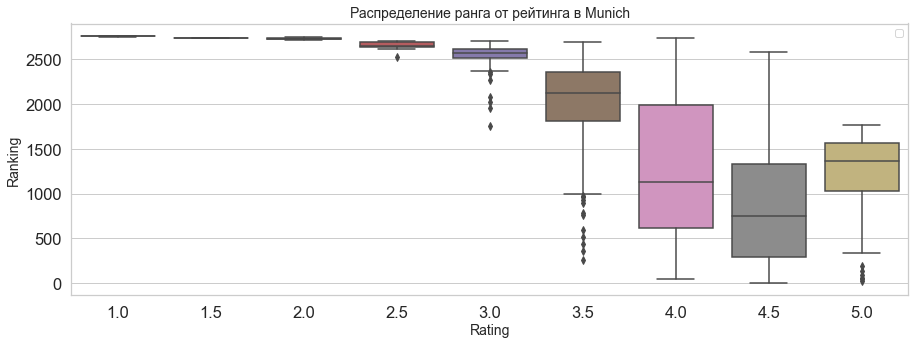

No handles with labels found to put in legend.


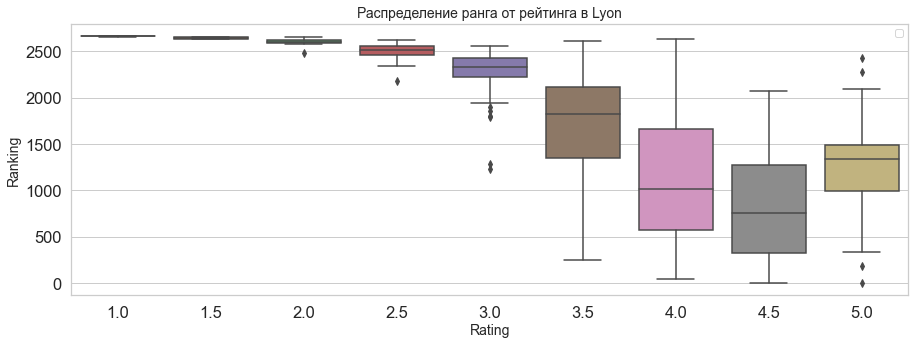

No handles with labels found to put in legend.


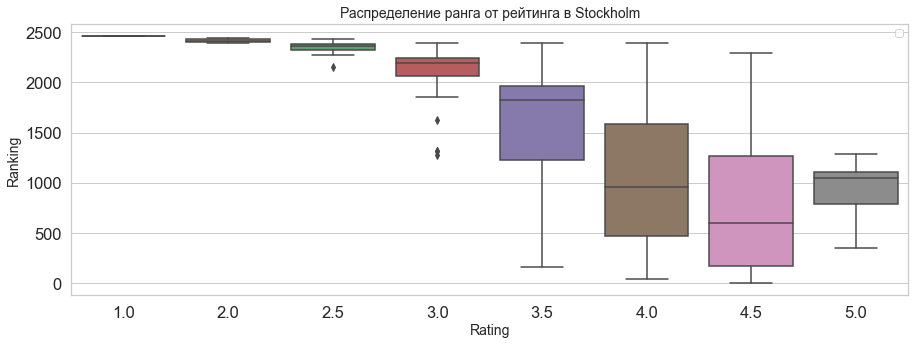

No handles with labels found to put in legend.


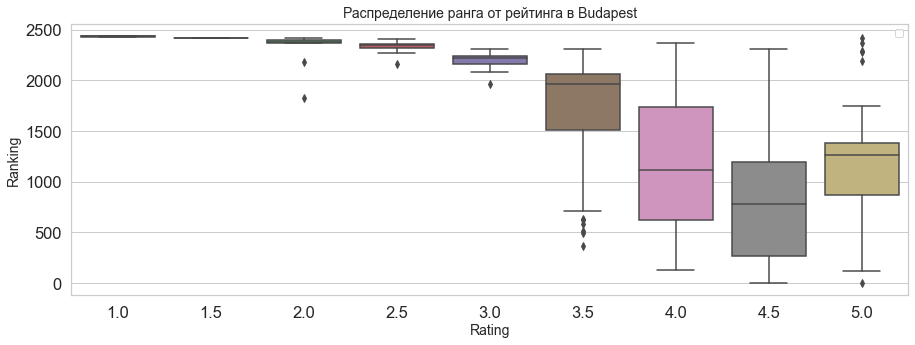

No handles with labels found to put in legend.


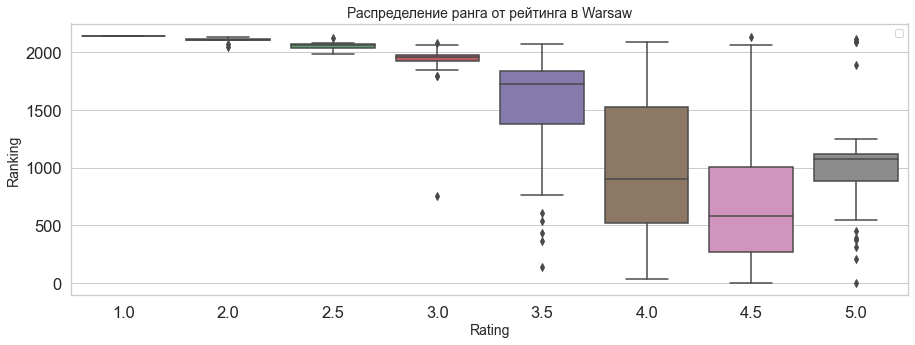

No handles with labels found to put in legend.


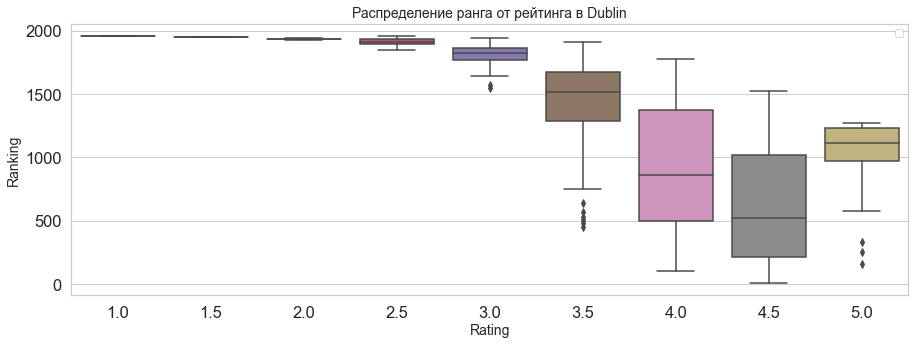

No handles with labels found to put in legend.


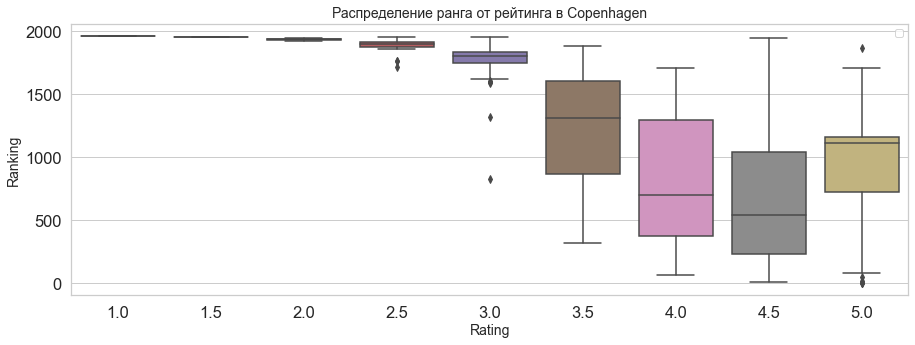

No handles with labels found to put in legend.


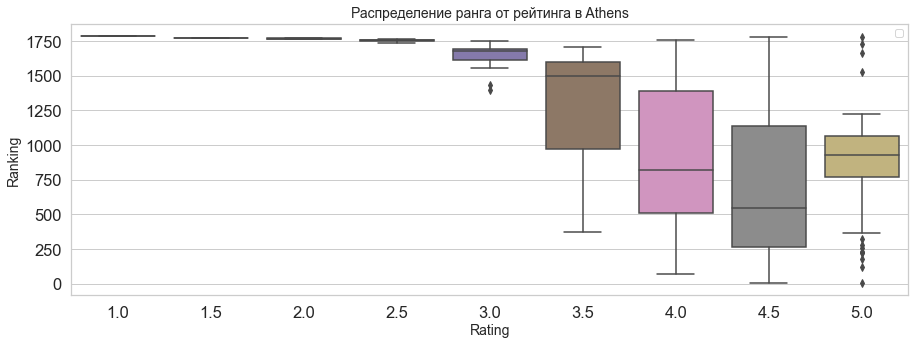

No handles with labels found to put in legend.


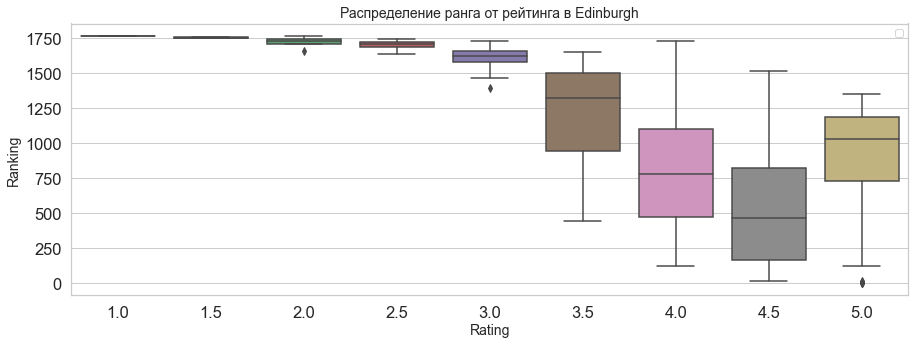

No handles with labels found to put in legend.


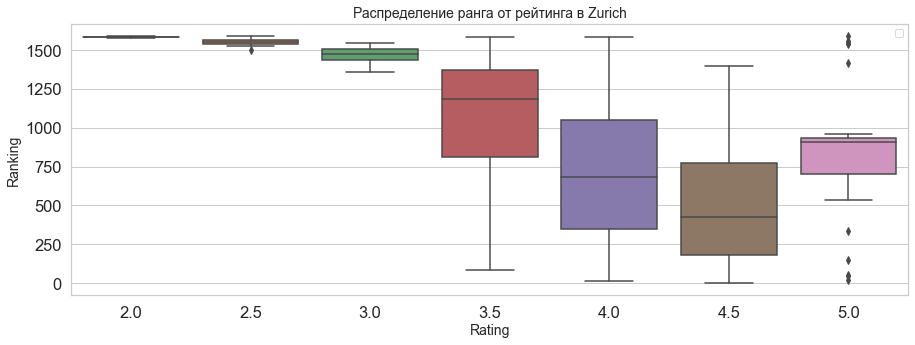

No handles with labels found to put in legend.


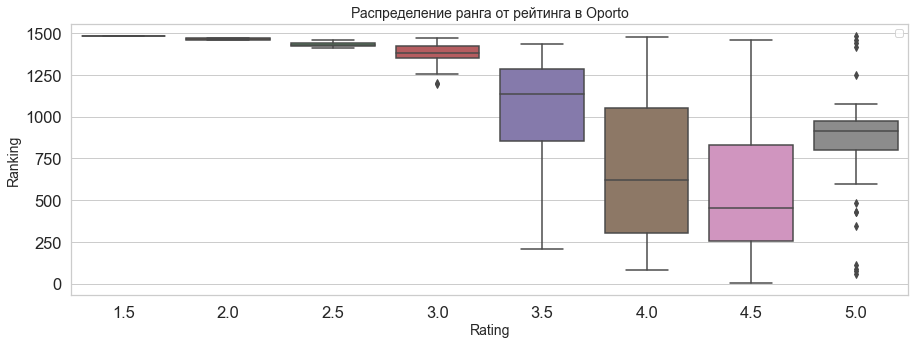

No handles with labels found to put in legend.


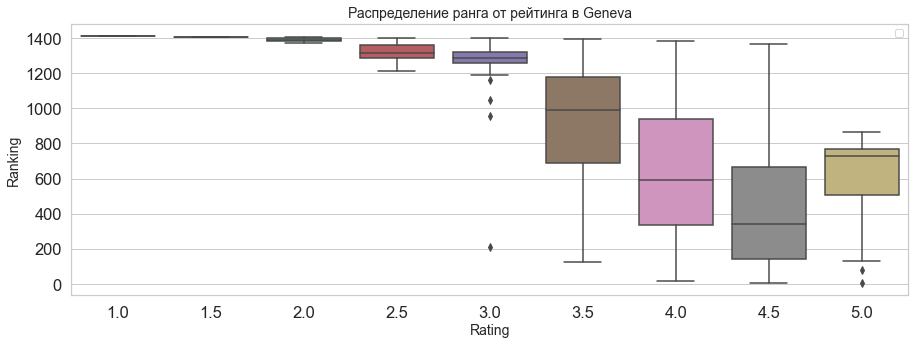

No handles with labels found to put in legend.


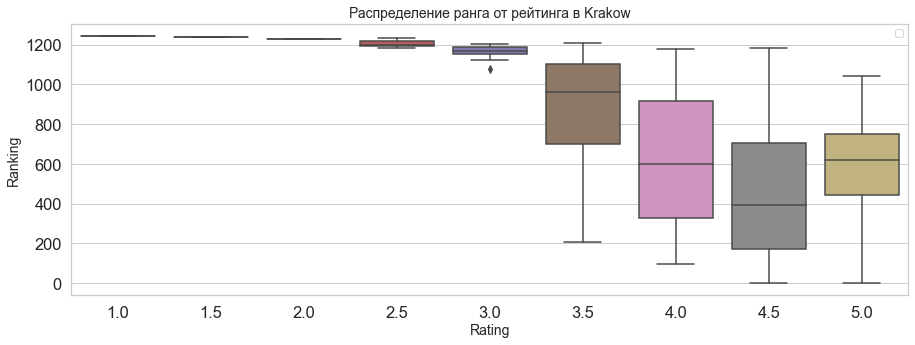

No handles with labels found to put in legend.


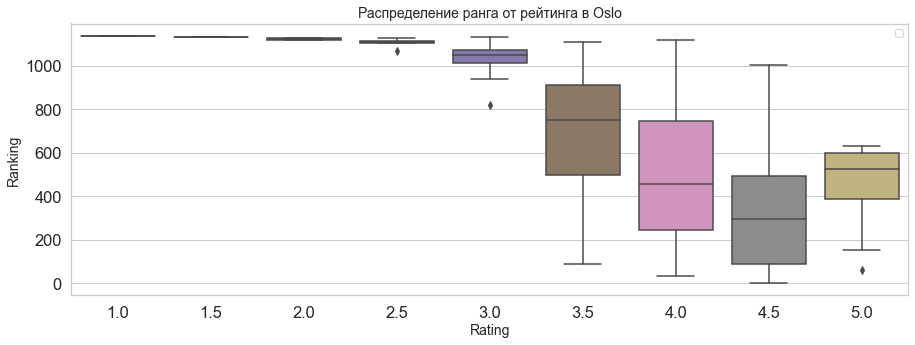

No handles with labels found to put in legend.


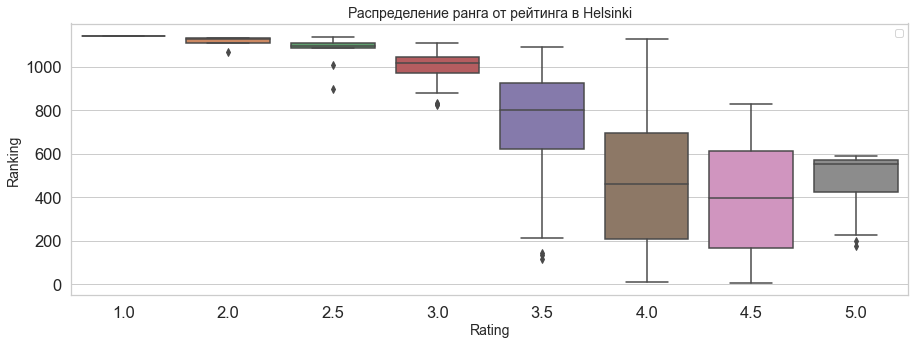

No handles with labels found to put in legend.


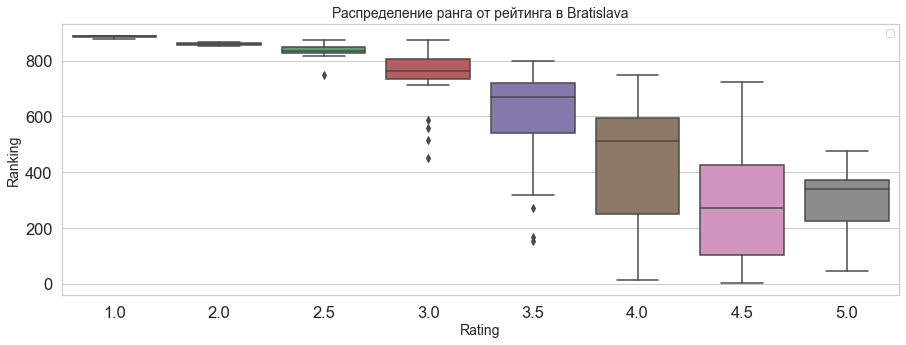

No handles with labels found to put in legend.


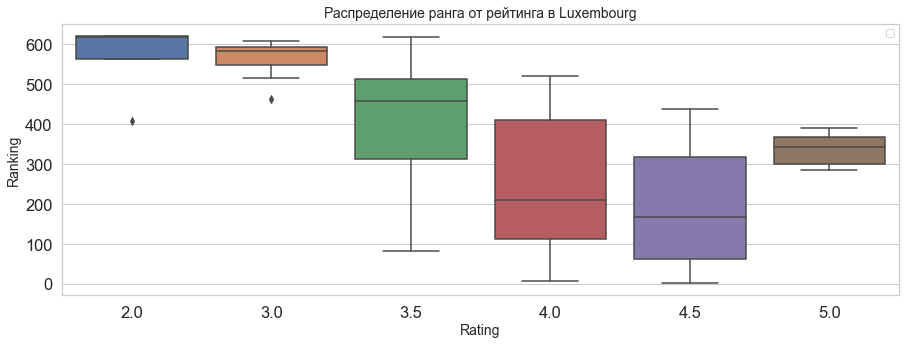

No handles with labels found to put in legend.


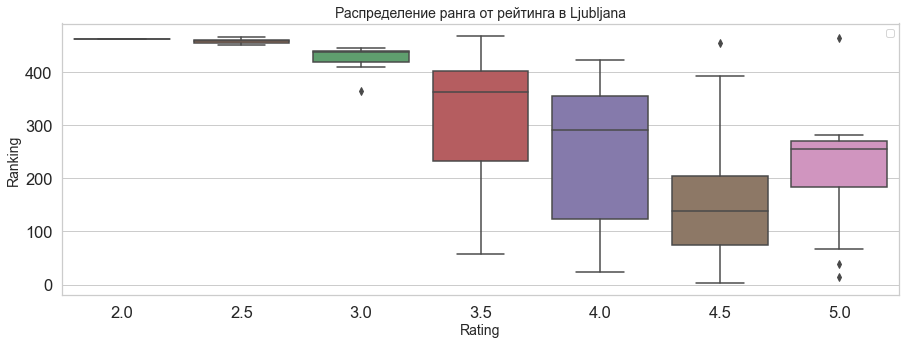

In [52]:
for city in (df_train['City'].value_counts()).index:
    fig, ax = plt.subplots(figsize=(15, 5))
    section = df_train[df_train['City'] == city]
    sns.boxplot(x = 'Rating', y = 'Ranking', data = section)
    plt.title(f'Распределение ранга от рейтинга в {city}', fontsize=14)
    plt.xlabel('Rating', fontsize=14)
    plt.ylabel('Ranking', fontsize=14)
    ax.legend(prop={'size': 10})
    plt.show()

=> Практически везде тенденция схожа. Интересно, что в Риме нет оценки ниже 3. Поэтому логично, что расположение ресторана в Риме - один из наиболее весомых признаков при построениии модели МО (был на первых этапах анализа)

### Запускаем модель и проверяем что получилось

In [53]:
# Удалим нечисловые признаки
object_columns = [s for s in data.columns if (data[s].dtypes == 'object') or (data[s].dtypes == 'datetime64')]
data.drop(object_columns, axis = 1, inplace=True)
data.drop(['first_date', 'second_date', 'chain'], axis = 1, inplace=True)

In [54]:
data.columns

Index(['Ranking', 'Price Range', 'Number of Reviews', 'ID_TA', 'sample',
       'Rating', 'population', 'Number_of_Reviews_isNAN', 'city_ranking',
       'salary', 'Reviews_in_the_city', 'Ranking_to_Review_number_in_the_city',
       'Reviews_in_the_city_median',
       'Ranking_to_median_Review_number_in_the_city', 'City_Amsterdam',
       'City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava',
       'City_Brussels', 'City_Budapest', 'City_Copenhagen', 'City_Dublin',
       'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki',
       'City_Krakow', 'City_Lisbon', 'City_Ljubljana', 'City_London',
       'City_Luxembourg', 'City_Lyon', 'City_Madrid', 'City_Milan',
       'City_Munich', 'City_Oslo', 'City_Paris', 'City_Porto', 'City_Prague',
       'City_Rome', 'City_Stockholm', 'City_Vienna', 'City_Warsaw',
       'City_Zurich', 'date_of_review_differece', 'Seasons_WINTER',
       'Seasons_SPRING', 'Seasons_SUMMER', 'Seasons_FALL', 'holiday_1', 'Bar',
       'Fre

In [55]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [56]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 64), (40000, 64), (40000, 63), (32000, 63), (8000, 63))

# Model 
Сам ML

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [59]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [60]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19570749999999998


<AxesSubplot:>

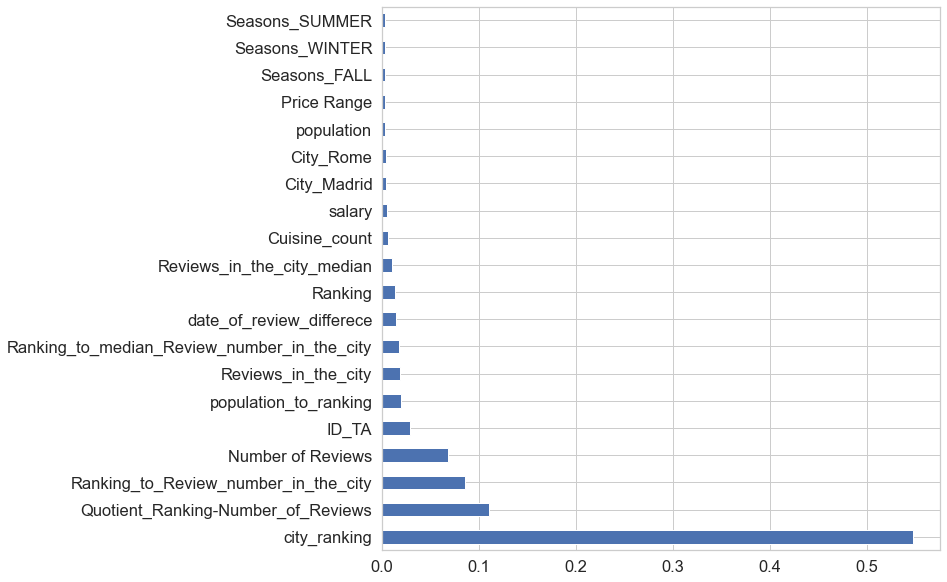

In [62]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [63]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,ID_TA,Rating,population,Number_of_Reviews_isNAN,city_ranking,salary,Reviews_in_the_city,...,European,Gluten Free Options,Vegan Options,Asian,Vegetarian Friendly,Spanish,Mediterranean,Cuisine_count,Quotient_Ranking-Number_of_Reviews,population_to_ranking
5893,801.0,2.0,6.0,12186522,0.0,972647.0,0,0.325081,2750,71588.0,...,0,0,0,0,0,0,0,21,4806.0,1214.290886
3290,6682.0,2.0,3.0,12964169,0.0,11020000.0,0,0.477763,2600,680827.0,...,0,0,0,0,0,0,0,2,20046.0,1649.206824
2845,403.0,2.0,98.0,3840790,0.0,693494.0,0,0.354442,3600,46602.0,...,0,1,1,1,1,0,0,7,39494.0,1720.828784
6471,1809.0,2.0,2.0,11904996,0.0,1471508.0,0,0.654723,5000,82386.0,...,0,0,0,0,0,0,0,21,3618.0,813.437258
7343,14094.0,2.0,7.0,6439158,0.0,10979000.0,0,0.857091,4131,933770.0,...,0,0,0,0,0,0,0,21,98658.0,778.983965
3555,3976.0,2.0,4.0,12710930,0.0,6026000.0,0,0.451357,1900,357185.0,...,0,0,0,0,0,1,0,2,15904.0,1515.593561
8715,1056.0,2.0,47.0,7616447,0.0,1911191.0,0,0.306620,5350,106709.0,...,0,0,0,0,0,0,0,1,49632.0,1809.839962
969,434.0,2.0,298.0,697165,0.0,766739.0,0,0.348875,2150,67635.0,...,0,0,0,0,1,0,0,3,129332.0,1766.679724
2505,1558.0,2.0,6.0,5606331,0.0,1841179.0,0,0.569236,4400,48853.0,...,0,0,0,0,0,0,0,1,9348.0,1181.758023
8047,147.0,3.0,136.0,1346226,0.0,1471508.0,0,0.053203,5000,82386.0,...,1,0,0,0,1,0,1,4,19992.0,10010.258503


In [64]:
test_data = test_data.drop(['Rating'], axis=1)

In [65]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [66]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [67]:
predict_submission

array([3.045, 4.115, 4.385, ..., 3.03 , 4.465, 4.19 ])

In [68]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.045
1,id_1,4.115
2,id_2,4.385
3,id_3,4.410
4,id_4,4.485
5,id_5,4.485
6,id_6,1.160
7,id_7,3.365
8,id_8,4.160
9,id_9,4.570
